# Hands-On NLP — Class 2

<span style="color:magenta">Group members:</span>

* Carlos Cuevas Villarmín
* Javier Alejandro Lopetegui González
* José Felipe Espinosa Orjuela

## Outline

- Embeddings from scratch

- Classifications with embeddings

In [20]:
from pathlib import Path

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from nltk.tokenize import word_tokenize
from sklearn import (
    decomposition,
    ensemble,
    linear_model,
    metrics,
    model_selection,
    multiclass,
    naive_bayes,
    neighbors,
    svm,
    tree,
)
#import pca
from sklearn.decomposition import PCA

from sklearn.feature_extraction.text import CountVectorizer
from tqdm.notebook import tqdm

In [5]:
tqdm.pandas()

nltk.download("punkt")

print("sklearn", sklearn.__version__)   # 1.3.2

sns.set_style("darkgrid")
sns.set_context("notebook")

pd.set_option("display.precision", 2)

sklearn 1.3.0


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/javierlopetegui/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
%config InlineBackend.figure_format="retina"  # For high DPI display

# %load_ext blackcellmagic

In [7]:
DATA = Path("./data")

TEXT_P = DATA / "texts"

CORPORA = [
    "mythology",
    "woodworking",
    "robotics",
    "hsm",
    "health",
    "portuguese",
]

EPS = np.finfo(float).eps

## Getting the data

In [8]:
corpora = {}
stats = []

for corpus in tqdm(CORPORA):
    print(corpus)
    texts = []
    for fp in (TEXT_P / corpus).glob("*.txt"):
        with fp.open() as f:
            texts.append(f.read())

    corpora[corpus] = "".join(texts)

    stats.append(
        {
            "corpus": corpus,
            "files_n": len(texts),
            "chars_n": len(corpora[corpus]),
        }
    )

df = pd.DataFrame.from_records(stats, index=["corpus"])
df["text"] = [corpora[corpus] for corpus in corpora]
df

  0%|          | 0/6 [00:00<?, ?it/s]

mythology
woodworking
robotics
hsm
health
portuguese


,files_n,chars_n,text
corpus,,,
mythology,1428,4689305,Q:\n\nCan anyone identify what Chinese mytholo...
woodworking,2461,6729416,Q:\n\nGlue-up for butcher block-style countert...
robotics,2981,7254006,Q:\n\nHow is this torque value arrived?\n\nI'm...
hsm,2329,7364214,"Q:\n\nWhen and why did people stopped using ""n..."
health,3412,9148631,Q:\n\nHelp reading an eyeglass prescription: W...
portuguese,1840,4415251,"Q:\n\nQual a origem da expressão ""o fim da pic..."


### Tokenizing

In [9]:
# If your machine is slow, pickeling allows to go faster next time.

tokens_fp = DATA / "tokens.pkl"
try:
    tokens = pd.read_pickle(tokens_fp)
except FileNotFoundError:
    tokens = df.text.progress_map(word_tokenize)
    tokens.to_pickle(tokens_fp)

In [10]:
df["tokens"] = tokens
df["tokens_n"] = df.tokens.map(len)
df["types_n"] = df.tokens.map(set).map(len)
df

,files_n,chars_n,text,tokens,tokens_n,types_n
corpus,,,,,,
mythology,1428,4689305,Q:\n\nCan anyone identify what Chinese mytholo...,"[Q, :, Can, anyone, identify, what, Chinese, m...",942599,51253
woodworking,2461,6729416,Q:\n\nGlue-up for butcher block-style countert...,"[Q, :, Glue-up, for, butcher, block-style, cou...",1390532,32318
robotics,2981,7254006,Q:\n\nHow is this torque value arrived?\n\nI'm...,"[Q, :, How, is, this, torque, value, arrived, ...",1526904,53833
hsm,2329,7364214,"Q:\n\nWhen and why did people stopped using ""n...","[Q, :, When, and, why, did, people, stopped, u...",1445136,62464
health,3412,9148631,Q:\n\nHelp reading an eyeglass prescription: W...,"[Q, :, Help, reading, an, eyeglass, prescripti...",1714931,66006
portuguese,1840,4415251,"Q:\n\nQual a origem da expressão ""o fim da pic...","[Q, :, Qual, a, origem, da, expressão, ``, o, ...",907242,60282


## Vectorization

### 🚧 TODO: How to vectorize text?

- Try counting words in the stackoverflow corpus based on a given vocabulary

- Apply reduction techniques to reduce the dimensionality to 2 dimensions (e.g., PCA)

- Plot the 2D vectors

In [62]:
words = (
    "myth,wood,robot,history,science,mathematics,health,portuguese,o".split(",")
)

wc_df = pd.DataFrame(index=df.index)
for w in words:
    wc_df[w] = df.tokens.map(lambda x:x.count(w))


In [63]:
wc_df

,myth,wood,robot,history,science,mathematics,health,portuguese,o
corpus,,,,,,,,,
mythology,769,55,6,179,21,4,18,0,27
woodworking,5,7535,0,18,9,0,48,0,2
robotics,0,21,4895,23,22,43,3,0,63
hsm,26,14,2,921,846,1578,28,1,25
health,46,10,1,207,114,6,1576,1,3
portuguese,2,11,3,13,3,1,8,41,14589


In [64]:
pca_model = PCA(n_components=2, random_state=42)
wc_df_pca = pca_model.fit_transform(wc_df)
wc_df_pca

array([[-2172.11807505, -1204.418861  ],
       [-3185.9537627 ,  5969.32416384],
       [-2446.45160229, -2479.24649585],
       [-2214.38228703, -1352.87210068],
       [-2215.38517532, -1297.79394626],
       [12234.29090238,   365.00723994]])

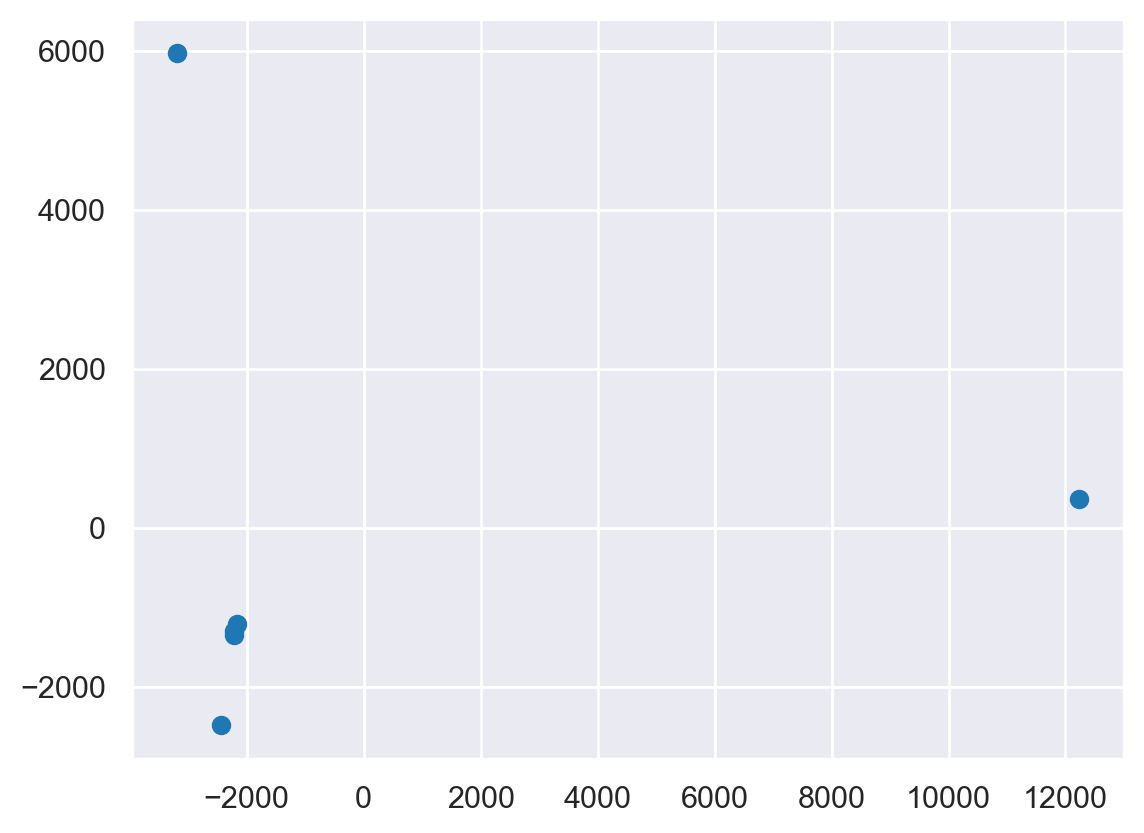

In [65]:
plt.scatter(wc_df_pca[:,0],wc_df_pca[:,1])

#### Bag of words

### 🚧 TODO: Implement another bag of words vectorizer model on the corpus

*   This time using [sklearn's `CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

*   Try first the provided example in the `CountVectorizer` documentation

    Try with and without the n-gram parameter

*   Then try to vectorize the stackoverflow corpus using `vocabulary=words`

#### First with a toy example

In [36]:
corpus = [
    "This is the first document.",
    "This document is the second document.",
    "And this is the third one.",
    "Is this the first document?",
]

With the whole vocabulary

In [38]:
vectorizer = CountVectorizer()
xs = vectorizer.fit_transform(corpus)

print(vectorizer.get_feature_names_out())
print(xs.toarray())

vectorizer_2g = CountVectorizer(analyzer='word', ngram_range=(2,2))
x2gs = vectorizer_2g.fit_transform(corpus)

print(vectorizer_2g.get_feature_names_out())
print(x2gs.toarray())

['and' 'document' 'first' 'is' 'one' 'second' 'the' 'third' 'this']
[[0 1 1 1 0 0 1 0 1]
 [0 2 0 1 0 1 1 0 1]
 [1 0 0 1 1 0 1 1 1]
 [0 1 1 1 0 0 1 0 1]]
['and this' 'document is' 'first document' 'is the' 'is this'
 'second document' 'the first' 'the second' 'the third' 'third one'
 'this document' 'this is' 'this the']
[[0 0 1 1 0 0 1 0 0 0 0 1 0]
 [0 1 0 1 0 1 0 1 0 0 1 0 0]
 [1 0 0 1 0 0 0 0 1 1 0 1 0]
 [0 0 1 0 1 0 1 0 0 0 0 0 1]]


In [39]:
cv_df = pd.DataFrame(xs.toarray(), columns=vectorizer.get_feature_names_out())
cv_df.insert(0, "Document", corpus)
cv_df

,Document,and,document,first,is,one,second,the,third,this
0,This is the first document.,0,1,1,1,0,0,1,0,1
1,This document is the second document.,0,2,0,1,0,1,1,0,1
2,And this is the third one.,1,0,0,1,1,0,1,1,1
3,Is this the first document?,0,1,1,1,0,0,1,0,1


With a subset of the vocabulary

In [43]:
vocabulary = ["and", "document", "first"]
vectorizer = CountVectorizer(vocabulary=vocabulary)
x_fix_voc = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names_out())
print(x_fix_voc.toarray())

['and' 'document' 'first']
[[0 1 1]
 [0 2 0]
 [1 0 0]
 [0 1 1]]


#### Reprocess the stackoverflow corpora with `CountVectorizer`

In [51]:
vectorizer = CountVectorizer(vocabulary=words)

wc_cv = pd.DataFrame(index=df.index)
wc_cv = vectorizer.fit_transform(df.text)
wc_cv_df = pd.DataFrame(wc_cv.toarray(), columns=vectorizer.get_feature_names_out(), index=df.index)
wc_cv_df

,myth,wood,robot,history,science,mathematics,health,portuguese,o
corpus,,,,,,,,,
mythology,867,75,6,307,35,4,23,4,0
woodworking,5,8017,1,19,16,0,53,0,0
robotics,0,22,5321,25,33,50,3,2,0
hsm,28,17,2,1513,1174,2095,39,7,0
health,55,13,1,242,263,9,2178,4,0
portuguese,2,13,3,18,7,3,9,1061,0


In [57]:
print(vectorizer.transform(['mythology']).toarray())

[[0 0 0 0 0 0 0 0 0]]


### 🚧 TODO: Why is this different? 

- Try to explain

- Give a simple example with the toy corpus below (with the same vocabulary)

In [ ]:
test_text = (
    "myth wood robot history science mathematics health portuguese o "
    "myth wood robot history science mathematics health portuguese o"
)

# freqs = ...

# test_wc_df = ...

In [ ]:
# test_xs = vectorizer...

# test_cv_df = ...

### 🚧 TODO: Is this difference important?

• Visualize the PCAs of both models

-----------

### Now let's hold the corpus as individual documents

In [ ]:
data = []

for i, corpus in enumerate(tqdm(CORPORA)):
    print(corpus)
    for fp in (TEXT_P / corpus).glob("*.txt"):
        with fp.open() as f:
            text = f.read()
        data.append(
            {
                "id": fp.stem,
                "text": text,
                "category": corpus,
                "cat_id": i,
            }
        )

In [ ]:
doc_df = pd.DataFrame.from_records(data).set_index("id")
doc_df

#### 🚧 TODO: Plot (bar) the number of documents per category

In [ ]:
# doc_df...

#### 🚧 TODO: Boxplot the number of tokens per document

* With and without outliers

* Shortly explain the different values presented in a boxplot ([Wikipedia](https://en.wikipedia.org/wiki/Box_plot))

* Are the texts of signifcantly different length? Argue shortly.

In [ ]:
# Careful: slow!

# doc_df["tokens_n"] ...

#### 🚧 TODO: How to find the crazy long robotics text?

*   Find the index of the longest text

*   Show the content

*   Explain why this text is so long (what does it contain?)

In [ ]:
# longests_df = doc_df[...

### Vectorizing again

#### 🚧 TODO: See how many features we get if we don't restrict their number

* Use again the `CountVectorizer` to vectorize the stackoverflow corpus

  * But use the whole vocabulary of the documents this time (**without** `vocabulary=words`)

  * Tell how many features are obtained

* Then limit the vocabulary to the 5000 most frequent words

* Apply and plot dimensionality reduction to 2 dimensions as prevously 
  (only on the limited vocabulary)

We want something like this:

```python
xs ~ doc_df.text
ys ~ doc_df.cat_id
```

In [ ]:
ys = doc_df.cat_id.values

In [ ]:
# unconstrained_cv = CountVectorizer()
# xs = ...

In [ ]:
# cv = CountVectorizer(max_features=5000)
# xs = ...

In [ ]:
# pca = ...

#### 🚧 TODO: Find that outlier!

* Use pandas to find the document corresponding to the outlier

* Print the correspoding text
  
* Tell what it contains (if you could figure it out)

* Remove the corresping raw from the dataframe and redo the dimensional reduction (and plot)

#### 🚧 TODO: The reason for this outlier is...

*   Give a short explanation

*   Remove the outlier from the dataframe 

*   Redo the dimensional reduction

*   Plot the 2D vectors and color them by category

## Train models to predict text subjects

### Split the data in training and test sets

In [ ]:
train_xs, test_xs, train_ys, test_ys = model_selection.train_test_split(
    xs, ys, test_size=0.3, random_state=0, shuffle=True
)
print(train_xs.shape)
print(test_xs.shape)

### 🚧 TODO: Apply different algorithms to try predicting the category

* E.g., Logistic Regression, Multinomial Naive Bayes, Decision Tree Classifier, Random Forest, Support Vector Classifer.

* You could investigate [`SGDClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html), which implements linear classifiers (e.g, SVM, logistic regression) with SGD training (faster).

* Present a table with the results of the different algorithms (e.g., accuracy, precision, recall, f1-score) and their execution time

* (Optional) Analyse 1 algorythm in detail (e.g., Logistic Regression)

  *   Try different parameters (possibly with a grid search)

  *   Present the [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)

  *   Present the confusion matrix of the best model

### 🚧 TODO: Explain what model seems to work best

____